#metaBEAT analysis of Illumina MiSeq output for Lake project_Cytb_Dec_2016

Mark sure your metaBEAT image version is the latest

`metaBEAT - metaBarcoding and Environmental DNA Analyses tool version: v.0.97.9-global`
Update from your terminal

####check the image, the latest ID should be f2646ec2d352

sudo docker images
####if not, use the command to update the image from your terminal

sudo docker pull chrishah/metabeat


###The first step will be to trim/clean our raw Illumina data

In [1]:
!pwd

/home/working


In [ ]:
!mkdir trimming

In [3]:
cd trimming

/home/working/trimming


__Prepare Querymap__

Prepare a text file specifying the samples to be processed including the format and location of the reads. 

The below command expects the Illumina data to be present in 2 fastq files (forward and reverse reads) per sample in a directory `../raw_reads/`. It expects the files to be named 'sampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively. 

The raw data need to be downloaded with `How_to_download_Rawdata_from_SRA.ipynb` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2018_eDNA_fish_monitoring/blob/master/Cytb/How_to_download_Cytb_Rawdata_from_SRA.ipynb))

SampleID must corresponds to the first column in the file `Sample_accessions.tsv` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2018_eDNA_fish_monitoring/blob/master/Cytb/supplementary_data/Sample_accessions.tsv)), marker is `Cytb`.


In [4]:

%%bash

for a in $(cat ../supplementary_data/Sample_accessions.tsv | grep "Cytb" | cut -f 1 | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a-Cytb_* | grep "_R1.fastq")
    R2=$(ls -1 ../raw_reads/$a-Cytb_* | grep "_R2.fastq")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

The resulting file should look e.g. like below:

In [5]:
!head Querymap.txt

BET01	fastq	../raw_reads/BET01-Cytb_R1.fastq.gz	../raw_reads/BET01-Cytb_R2.fastq.gz
BET02	fastq	../raw_reads/BET02-Cytb_R1.fastq.gz	../raw_reads/BET02-Cytb_R2.fastq.gz
BET03	fastq	../raw_reads/BET03-Cytb_R1.fastq.gz	../raw_reads/BET03-Cytb_R2.fastq.gz
BET04	fastq	../raw_reads/BET04-Cytb_R1.fastq.gz	../raw_reads/BET04-Cytb_R2.fastq.gz
BET05	fastq	../raw_reads/BET05-Cytb_R1.fastq.gz	../raw_reads/BET05-Cytb_R2.fastq.gz
BET06	fastq	../raw_reads/BET06-Cytb_R1.fastq.gz	../raw_reads/BET06-Cytb_R2.fastq.gz
BET07	fastq	../raw_reads/BET07-Cytb_R1.fastq.gz	../raw_reads/BET07-Cytb_R2.fastq.gz
BET08	fastq	../raw_reads/BET08-Cytb_R1.fastq.gz	../raw_reads/BET08-Cytb_R2.fastq.gz
BET09	fastq	../raw_reads/BET09-Cytb_R1.fastq.gz	../raw_reads/BET09-Cytb_R2.fastq.gz
BET10	fastq	../raw_reads/BET10-Cytb_R1.fastq.gz	../raw_reads/BET10-Cytb_R2.fastq.gz


###Raw data trimming, removal of adapter sequences and merging of readsusing the `metaBEAT` pipeline.

__The manual of metaBEAT_global.py can run the command as below__


In [ ]:
!metaBEAT_global.py -h

In [7]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap.txt \
--trim_qual 30 \
--trim_minlength 100 \
--merge --product_length 400 --forward_only \
-@ haikuilee@gmail.com \
-n 5 -v &> log_trimming

echo -e "Endtime: $(date)\n"

Starttime: Tue Dec 12 12:23:46 UTC 2017

Endtime: Wed Dec 13 05:20:53 UTC 2017



__After trimming, there is no queries under sample "LGSB1", then it will not been included in "chimera detection"__

__Query survival after trimming__

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `metaBEAT_read_stats.csv`.

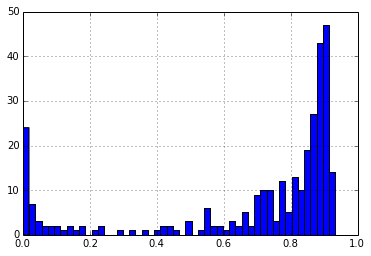

In [8]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

In [9]:
cd ../

/home/working


###Next stage of the processing is chimera detection and removal of putative chimeric sequences

We'll do that using `uchime` as implemented in `vsearch`.

In [10]:
!mkdir chimera_detection

In [11]:
cd chimera_detection

/home/working/chimera_detection


__Prepare REFmap__

Convert reference database from Genbank to fasta format to be used in chimera detection.

Prepare Refmap file, i.e. text file that specifies the location and the format of the reference to be used.

The reference sequences in Genbank format should already be present in the `supplementary_data` directory: `Cytb_evohull_DEC_2017.gb`
 and  `Astatotilapia_calliptera.gb` is positive control

In [12]:
%%bash

#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt

In [ ]:
!cat REFmap.txt

__Transfer reference DB from gb to fasta format__

This will produce `refs.fasta`

In [ ]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f \
-@ haikuilee@gmail.com

In [ ]:
!head -2 refs.fasta


__Now run chimera detection__

In [ ]:
%%bash

echo -e "Starttime: $(date)\n"

for a in $(cut -f 1 ../trimming/Querymap.txt)
do
    if [ -s ../trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log
        cd ..

    else
        echo -e "$a is empty"
    fi
done

echo -e "Endtime: $(date)\n"


### Last step is taxonomic assignment of reads based on a BLAST - LCA approach using the metaBEAT pipeline

In [17]:
cd ..

/home/working


In [1]:
!mkdir non-chimeras

In [2]:
cd non-chimeras/

/home/working/non-chimeras


__Prepare Querymap and Refmap txt files__

__To skip the `GLOBAL` folder under chimeras detection, add a new line in below command  if [ "$a" != "GLOBAL" ]__


In [3]:
%%bash

#Querymap
for a in $(ls -l ../chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
   if [ "$a" != "GLOBAL" ]
   then
      echo -e "$a-nc\tfasta\t../chimera_detection/$a/$a-nonchimeras.fasta"
   fi
done > Querymap.txt



#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt


In [ ]:
!head -10  Querymap.txt

In [ ]:
!cat REFmap.txt

__Sequence clustering and taxonomic assignment via metaBEAT__

In [6]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap.txt \
-R REFmap.txt \
--cluster --clust_match 1 --clust_cov 3 \
--blast --min_ident 0.95 \
-m Cytb -n 5 \
-E -v \
-@  haikuilee@gmail.com \
-o Cytb_LP-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_0.95 &> log_non-chimeras

echo -e "Endtime: $(date)\n"

Starttime: Fri Dec 15 14:54:17 UTC 2017

Endtime: Fri Dec 15 16:26:16 UTC 2017



__Results are under the `GLOBAL` folder__
